## Using XyloSamna to run tests on Xylo SNN Core 
In this tutorial we go through an example of deploying an audio classification model trained in Rockpool into SNN Core XyloAudio 3 in `accelerated time mode` using `XyloSamna`. Steps are following:

- To load, map and quantize the trained checkpoint with tools and transforms from Rockpool

- To build the config object for SNN Core 

- Instantiate a `XyloSamna` by passing the config object and connecting Xylo HDK device

- Feeding the input (pre generated spike train)

- Analyze the output of SNN Core 

### Loading the trained model
In this example we use a trained model for a binary classification task: detection of baby cry. The model is composed of 16 input channels 3 layers of LIF neurons and one single output neuron.  

In [50]:
from rockpool.nn.networks import SynNet
from rockpool.nn.modules import LIFExodus
import warnings
warnings.filterwarnings("ignore")

ckpt = 'test_model/to_deploy_inXyloSim.json'

#  trained model architecture parameters
arch_params = {'n_classes': 1,
'n_channels': 16,
'size_hidden_layers':[63, 63, 63],
'time_constants_per_layer':[3,7,7],
'tau_syn_base': 0.002,
'tau_mem': 0.002,
'tau_syn_out': 0.002,
'neuron_model': LIFExodus,
'max_spikes_per_dt': 31,
'max_spikes_per_dt_out': 1,
'dt': 0.001,
'output': 'vmem'}

# instantiating the model and loading trained checkpoint
model = SynNet(** arch_params)
model.load(ckpt)

### To map, quantize and build config object for HDK 

In [2]:
from rockpool.devices.xylo.syns65302 import config_from_specification, mapper
import rockpool.transform.quantize_methods as q
# import samna

spec = mapper(model.as_graph(), weight_dtype='float', threshold_dtype='float', dash_dtype='float')
spec.update(q.channel_quantize(**spec))

xylo_conf, is_valid, msg = config_from_specification(**spec)
# xylo_conf.operation_mode = samna.xyloAudio3.OperationMode.AcceleratedTime

from samna.xyloA3.configuration import InputInterfaceConfig


### To create XyloSamna: API to interact with HDK in accelerated time
- XyloAudio 3 HDK needs to be connected to PC at this step 

In [3]:
from rockpool.devices.xylo.syns65302 import xa3_devkit_utils as hdu
from rockpool.devices.xylo.syns65302 import XyloSamna


xylo_nodes = hdu.find_xylo_a3_boards()
xa3 = xylo_nodes[0]
Xmod = XyloSamna(device=xa3, config=xylo_conf, dt = 0.01, record = True)

### To Feed the test sample to XyloSamna

In [4]:
import numpy as np

test_sample = np.load('test_afesim_sample/AFESimExternalSample.npy', allow_pickle=True)
out, _, rec = Xmod(test_sample)
print(f'number of output spikes:{out.sum()}')

number of output spikes:12


### Anlyzing Recorded states 
In `XyloSamna` by setting `record = True` at instantiation we can record spikes and internal states for output and hidden neurons of the model. This feature can be useful for debugging. For this eample we plot membrane potential of output neuron, output spikes and spikes of hidden neuron spikes 

Text(0.5, 1.0, 'hidden neuron spikes')

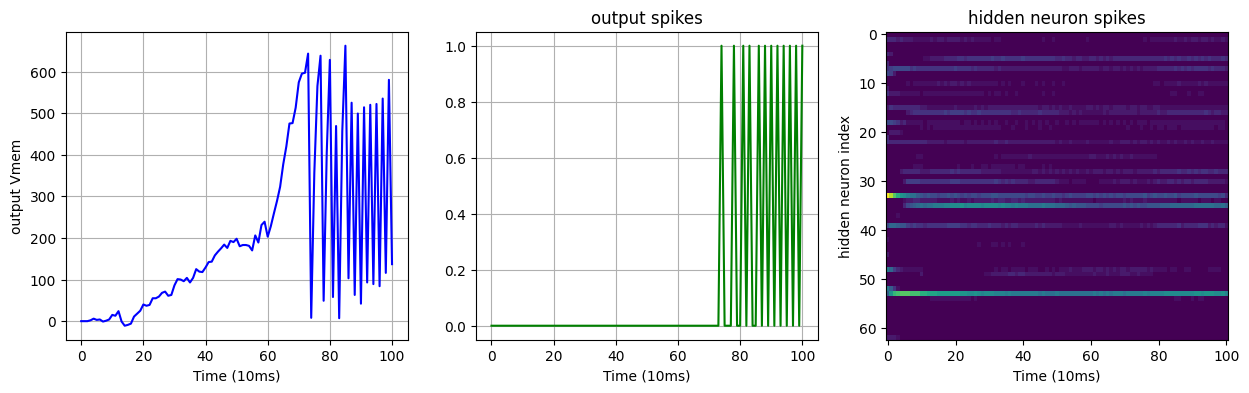

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,4))
plt.subplot(131); plt.plot(rec['Vmem_out'], 'b'); plt.grid(True); plt.xlabel('Time (10ms)'); plt.ylabel('output Vmem'); 
plt.subplot(132); plt.plot(out, 'g');plt.grid(True); plt.xlabel('Time (10ms)'); plt.title('output spikes'); 
plt.subplot(133); plt.imshow(rec['Spikes'].T, aspect='auto'); plt.xlabel('Time (10ms)'); plt.ylabel('hidden neuron index'); plt.title('hidden neuron spikes')
